In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import warnings
import os

import plotly.express as px
import matplotlib.pyplot as plt

from IPython.display import display
from IPython.display import display, Markdown

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score


In [2]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

<a id="3.1"></a>
## **Loading of Data**
The initial step involves importing the necessary datasets. The datasets to be loaded is the ASHRAE Global Thermal Comfort Dataset II file.

In [3]:
import pandas as pd

train = pd.read_csv('C:/Users/User/Desktop/AzureDigitalTwin/hvac_dataset.csv', low_memory=False)
train.head()


,Publication (Citation),Data contributor,Year,Season,Koppen climate classification,Climate,City,Country,Building type,Cooling startegy_building level,...,Subject«s height (cm),Subject«s weight (kg),Blind (curtain),Fan,Window,Door,Heater,Outdoor monthly air temperature (C),Outdoor monthly air temperature (F),Database
0,"Kwok, Alison G., and Chungyoon Chun. ""Thermal ...",Kwok Alison,2000.0,Summer,Cfa,Humid subtropical,Tokyo,Japan,Classroom,Air Conditioned,...,162.0,NaN,NaN,NaN,NaN,NaN,NaN,25.0,77.0,Database 2
1,"Kwok, Alison G., and Chungyoon Chun. ""Thermal ...",Kwok Alison,2000.0,Summer,Cfa,Humid subtropical,Tokyo,Japan,Classroom,Air Conditioned,...,154.0,NaN,NaN,NaN,NaN,NaN,NaN,25.0,77.0,Database 2
2,"Kwok, Alison G., and Chungyoon Chun. ""Thermal ...",Kwok Alison,2000.0,Summer,Cfa,Humid subtropical,Tokyo,Japan,Classroom,Air Conditioned,...,173.0,NaN,NaN,NaN,NaN,NaN,NaN,25.0,77.0,Database 2
3,"Kwok, Alison G., and Chungyoon Chun. ""Thermal ...",Kwok Alison,2000.0,Summer,Cfa,Humid subtropical,Tokyo,Japan,Classroom,Air Conditioned,...,167.0,NaN,NaN,NaN,NaN,NaN,NaN,25.0,77.0,Database 2
4,"Kwok, Alison G., and Chungyoon Chun. ""Thermal ...",Kwok Alison,2000.0,Summer,Cfa,Humid subtropical,Tokyo,Japan,Classroom,Air Conditioned,...,178.0,NaN,NaN,NaN,NaN,NaN,NaN,25.0,77.0,Database 2


In [4]:
train.shape

(107583, 70)

<a id="3.2"></a>
## **Cleaning of Data**

In [5]:
# Clean the column names to ensure there are no hidden characters or whitespace
train.columns = train.columns.str.strip()

# If special characters like '«' or '¬´' exist, replace them
train.columns = train.columns.str.replace(r'[«¬´]', '\'', regex=True)  # Use regex for robustness

# Additional cleaning to handle potential special characters and non-printing characters
train.columns = train.columns.str.replace(r'[^\x00-\x7F]+', '', regex=True)  # Removes non-ASCII characters

# List of columns to drop
columns_to_drop = [
    'Publication (Citation)', 'Data contributor', 'Season', 'Koppen climate classification', 
    'Climate', 'City', 'Cooling startegy_operation mode for MM buildings', 
    'Heating strategy_building level', 'PMV', 'PPD', 'SET', 'Met', 'activity_10', 
    'activity_20', 'activity_30', 'activity_60', 'Air temperature (F)', 'Ta_h (F)', 
    'Operative temperature (C)', 'Operative temperature (F)',  # Added both C and F versions
    'Ta_m (C)', 'Ta_m (F)', 'Ta_l (C)', 'Ta_l (F)', 
    'Radiant temperature (C)', 'Radiant temperature (F)', 'Globe temperature (F)', 
    'Tg_h (F)', 'Tg_m (C)', 'Tg_m (F)', 'Tg_l (C)', 'Tg_l (F)', 'Humidity preference', 
    'Humidity sensation', 'Air velocity (fpm)', 'Velocity_h (m/s)', 'Velocity_h (fpm)', 
    'Velocity_m (m/s)', 'Velocity_m (fpm)', 'Velocity_l (m/s)', 'Velocity_l (fpm)', 
    'Subject\'s weight (kg)', 'Blind (curtain)', 'Fan', 'Window', 'Door', 'Heater', 
    'Outdoor monthly air temperature (F)', 'Database'
]

# Drop the columns, using errors='ignore' to avoid issues with non-existent columns
train.drop(columns=columns_to_drop, axis=1, errors='ignore', inplace = True)

# Display the remaining columns count
print(train.shape)

(107583, 21)


In [6]:
# Display the modified DataFrame
train

,Year,Country,Building type,Cooling startegy_building level,Age,Sex,Thermal sensation,Thermal sensation acceptability,Thermal preference,Air movement acceptability,...,Thermal comfort,Clo,Air temperature (C),Ta_h (C),Globe temperature (C),Tg_h (C),Relative humidity (%),Air velocity (m/s),Subject's height (cm),Outdoor monthly air temperature (C)
0,2000.0,Japan,Classroom,Air Conditioned,15.0,Female,-0.5,1.0,warmer,1.0,...,5,0.25,24.2,24.2,24.0,24.0,50.2,0.06,162.0,25.0
1,2000.0,Japan,Classroom,Air Conditioned,15.0,Female,-2.1,1.0,no change,1.0,...,5,0.25,24.2,24.2,24.0,24.0,50.2,0.06,154.0,25.0
2,2000.0,Japan,Classroom,Air Conditioned,15.0,Male,0.5,1.0,no change,1.0,...,6,0.27,24.2,24.2,24.0,24.0,50.2,0.06,173.0,25.0
3,2000.0,Japan,Classroom,Air Conditioned,14.0,Female,-2.5,0.0,no change,1.0,...,4,0.23,24.2,24.2,24.0,24.0,50.2,0.06,167.0,25.0
4,2000.0,Japan,Classroom,Air Conditioned,15.0,Male,-0.5,1.0,no change,1.0,...,6,0.34,24.2,24.2,24.0,24.0,50.2,0.06,178.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107578,1996.0,USA,Classroom,Air Conditioned,17.0,Female,-2.1,1.0,no change,NaN,...,5,0.59,NaN,22.2,22.1,22.1,67.4,NaN,NaN,NaN
107579,1996.0,USA,Classroom,Air Conditioned,15.0,Female,-0.5,1.0,no change,NaN,...,5,0.44,NaN,22.2,22.1,22.1,67.4,NaN,NaN,NaN
107580,1996.0,USA,Classroom,Air Conditioned,16.0,Female,-1.0,1.0,no change,NaN,...,5,0.37,NaN,22.2,22.1,22.1,67.4,NaN,NaN,NaN
107581,1996.0,USA,Classroom,Air Conditioned,16.0,Male,1.0,1.0,cooler,NaN,...,4,0.80,NaN,22.2,22.1,22.1,67.4,NaN,NaN,NaN


We have successfully streamlined our dataset, reducing it to a more concise format with only 21 columns.

In [7]:
import pandas as pd
import plotly.express as px

# Remove rows with invalid Country data (e.g., missing country)
train = train[train["Country"].notna()]

# Group by country and count occurrences
country_count = train.groupby("Country").size().reset_index(name='Count')

# Display the country count table
print(country_count)

        Country  Count
0     Australia   8259
1       Belgium     85
2        Brazil   7390
3        Canada   2728
4         China   8213
5       Denmark    170
6        France    516
7       Germany   1055
8        Greece   1951
9         India  16110
10    Indonesia    596
11         Iran   1971
12        Italy    283
13        Japan    834
14     Malaysia    990
15       Mexico   1423
16      Nigeria    512
17     Pakistan   4199
18  Philippines    277
19     Portugal   1559
20    Singapore   1034
21     Slovakia    648
22  South Korea    574
23       Sweden    970
24     Thailand   1168
25      Tunisia   1651
26           UK  27273
27          USA  15144


As shown above, there are responses located outside Singapore. Hence, our objective is to eliminate these responses from the dataset.

#### Filtering By Country

In [8]:
# Filter the dataset to only include rows where the Country is 'Singapore'
singapore_data = train[(train['Country'] == 'Singapore') | (train['Country'] == 'Malaysia')]

from IPython.display import display

# Filter and sort the dataset
train = train[(train['Country'] == 'Singapore') | (train['Country'] == 'Malaysia')]
train = train.sort_values(by='Year', ascending=False)

# Display the entire filtered and sorted dataset in a 
# table format (Jupyter Notebook will automatically handle it nicely)
display(train)

,Year,Country,Building type,Cooling startegy_building level,Age,Sex,Thermal sensation,Thermal sensation acceptability,Thermal preference,Air movement acceptability,...,Thermal comfort,Clo,Air temperature (C),Ta_h (C),Globe temperature (C),Tg_h (C),Relative humidity (%),Air velocity (m/s),Subject's height (cm),Outdoor monthly air temperature (C)
25217,2014.0,Malaysia,Others,Air Conditioned,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,0.73,26.9,NaN,NaN,NaN,61.0,NaN,NaN,28.5
25281,2014.0,Malaysia,Others,Air Conditioned,NaN,NaN,3.0,NaN,NaN,NaN,...,NaN,0.84,30.4,NaN,NaN,NaN,69.0,NaN,NaN,28.5
25291,2014.0,Malaysia,Others,Air Conditioned,NaN,NaN,2.0,NaN,NaN,NaN,...,NaN,0.61,29.6,NaN,NaN,NaN,72.0,NaN,NaN,28.0
25290,2014.0,Malaysia,Others,Air Conditioned,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,0.73,28.8,NaN,NaN,NaN,72.0,NaN,NaN,28.0
25289,2014.0,Malaysia,Others,Air Conditioned,NaN,NaN,3.0,NaN,NaN,NaN,...,NaN,0.52,28.4,NaN,NaN,NaN,72.0,NaN,NaN,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101550,1986.0,Singapore,Office,Air Conditioned,NaN,Male,0.0,NaN,NaN,NaN,...,NaN,0.40,23.2,NaN,23.7,NaN,53.5,0.05,NaN,NaN
101549,1986.0,Singapore,Office,Air Conditioned,NaN,Male,0.0,NaN,NaN,NaN,...,NaN,0.40,23.2,NaN,23.7,NaN,53.5,0.05,NaN,NaN
101548,1986.0,Singapore,Office,Air Conditioned,NaN,Female,0.0,NaN,NaN,NaN,...,NaN,0.44,23.1,NaN,23.9,NaN,41.5,0.01,NaN,NaN
101547,1986.0,Singapore,Office,Air Conditioned,NaN,Female,0.0,NaN,NaN,NaN,...,NaN,0.78,23.1,NaN,23.9,NaN,41.5,0.05,NaN,NaN


<a id="3.3"></a>
## **Checking of Date**
Since the data collected in 1986 and 1987 is considered too outdated for the current context, we decided to exclude it from our analysis.

In [9]:
# Filter the dataset to only include rows where the Country is 'Singapore' and the Year is 1996
singapore_data_1996 = train[((train['Country'] == 'Singapore')  | (train['Country'] == 'Malaysia')) 
                        & (train['Year'] > 1990)]

from IPython.display import display

# Sort the filtered dataset by a specific column (if necessary)
singapore_data_1996 = singapore_data_1996.sort_values(by='Year', ascending=False)

display(singapore_data_1996)

,Year,Country,Building type,Cooling startegy_building level,Age,Sex,Thermal sensation,Thermal sensation acceptability,Thermal preference,Air movement acceptability,...,Thermal comfort,Clo,Air temperature (C),Ta_h (C),Globe temperature (C),Tg_h (C),Relative humidity (%),Air velocity (m/s),Subject's height (cm),Outdoor monthly air temperature (C)
25217,2014.0,Malaysia,Others,Air Conditioned,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,0.73,26.9,NaN,NaN,NaN,61.0,NaN,NaN,28.5
25242,2014.0,Malaysia,Others,Air Conditioned,NaN,NaN,-2.0,NaN,NaN,NaN,...,NaN,0.86,29.5,NaN,NaN,NaN,60.0,NaN,NaN,28.5
25266,2014.0,Malaysia,Others,Air Conditioned,NaN,NaN,-3.0,NaN,NaN,NaN,...,NaN,0.86,23.7,NaN,NaN,NaN,50.0,NaN,NaN,28.5
25219,2014.0,Malaysia,Others,Air Conditioned,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,0.62,24.1,NaN,NaN,NaN,61.0,NaN,NaN,28.5
25220,2014.0,Malaysia,Others,Air Conditioned,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,0.68,24.1,NaN,NaN,NaN,61.0,NaN,NaN,28.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81963,1996.0,Singapore,Office,Air Conditioned,NaN,NaN,-1.0,NaN,NaN,NaN,...,5,NaN,23.1,NaN,NaN,NaN,63.8,0.18,NaN,28.3
81964,1996.0,Singapore,Office,Air Conditioned,NaN,NaN,-2.0,NaN,NaN,NaN,...,5,NaN,23.1,NaN,NaN,NaN,63.8,0.18,NaN,28.3
81965,1996.0,Singapore,Office,Air Conditioned,NaN,NaN,0.0,NaN,NaN,NaN,...,5,NaN,23.1,NaN,NaN,NaN,63.8,0.18,NaN,28.3
81966,1996.0,Singapore,Office,Air Conditioned,NaN,NaN,-2.0,NaN,NaN,NaN,...,5,NaN,23.1,NaN,NaN,NaN,63.8,0.18,NaN,28.3


After filtering out responses from those years, 216 entries remain.

<a id="3.4"></a>
## **Filtering Out Missing and Redundant Data**
After narrowing the dataset to only include entries from Singapore in 1996, we noticed that several columns contained a significant amount of missing data, along with a column that held redundant information. Consequently, we decided to remove these columns from the dataset.

In [10]:
import pandas as pd
from IPython.display import display

# Filter the dataset to only include rows where the Country is 'Singapore' and the Year is 1996
singapore_data_1996 = train[((train['Country'] == 'Singapore')  | (train['Country'] == 'Malaysia'))
& (train['Year'] > 1990) & (train['Cooling startegy_building level'] == 'Air Conditioned') ]

# Remove columns that are entirely NA
singapore_data_1996_cleaned = singapore_data_1996.dropna(axis=1, how='all')

# Sort the filtered dataset by a specific column (if necessary)
singapore_data_1996_cleaned = singapore_data_1996_cleaned.sort_values(by='Year', ascending=False)

# Display the entire filtered and sorted dataset in a table format
display(singapore_data_1996_cleaned)

# Identify which columns were removed due to all NA values
na_removed_columns = singapore_data_1996.columns[singapore_data_1996.isna().all()]

# Combine NA removed columns first
all_removed_columns = na_removed_columns.tolist()  # No manually removed columns here

# Convert removed columns to a DataFrame for display in a table format
removed_columns_df = pd.DataFrame(all_removed_columns, columns=['Removed Columns'])

# Reset the index to start from 1 instead of 0
removed_columns_df.index = removed_columns_df.index + 1

# Display the removed columns in a table format with the index and center-align header, index, and content
styled_table = removed_columns_df.style.set_properties(**{'text-align': 'center'}).set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'center')]}]  # Align the header to center
)

# Display the styled table with the index starting from 1
display(styled_table)

,Year,Country,Building type,Cooling startegy_building level,Thermal sensation,Thermal comfort,Clo,Air temperature (C),Relative humidity (%),Air velocity (m/s),Outdoor monthly air temperature (C)
25217,2014.0,Malaysia,Others,Air Conditioned,0.0,NaN,0.73,26.9,61.0,NaN,28.5
25242,2014.0,Malaysia,Others,Air Conditioned,-2.0,NaN,0.86,29.5,60.0,NaN,28.5
25266,2014.0,Malaysia,Others,Air Conditioned,-3.0,NaN,0.86,23.7,50.0,NaN,28.5
25219,2014.0,Malaysia,Others,Air Conditioned,0.0,NaN,0.62,24.1,61.0,NaN,28.5
25220,2014.0,Malaysia,Others,Air Conditioned,0.0,NaN,0.68,24.1,61.0,NaN,28.5
...,...,...,...,...,...,...,...,...,...,...,...
81963,1996.0,Singapore,Office,Air Conditioned,-1.0,5,NaN,23.1,63.8,0.18,28.3
81964,1996.0,Singapore,Office,Air Conditioned,-2.0,5,NaN,23.1,63.8,0.18,28.3
81965,1996.0,Singapore,Office,Air Conditioned,0.0,5,NaN,23.1,63.8,0.18,28.3
81966,1996.0,Singapore,Office,Air Conditioned,-2.0,5,NaN,23.1,63.8,0.18,28.3


,Removed Columns
1,Age
2,Sex
3,Thermal sensation acceptability
4,Thermal preference
5,Air movement acceptability
6,Air movement preference
7,Ta_h (C)
8,Globe temperature (C)
9,Tg_h (C)
10,Subject's height (cm)


## **Aggregation of Environment Factors**
Calculating the mean values of air temperature, relative humidity, and air velocity for Singapore in 1996 serves several important purposes. These mean values provide a baseline for evaluating the overall climate conditions during that year, enabling direct comparison with our prediction model, helping us assess the accuracy and reliability of our forecasts. Ultimately, this analysis contributes to understanding how these factors influence thermal comfort levels, which is essential for effective building design.

In [11]:
# Define the columns you want to calculate the mean for
columns_to_calculate = ['Air temperature (C)', 'Relative humidity (%)', 'Air velocity (m/s)', 'Outdoor monthly air temperature (C)']

# Check if these columns exist in the cleaned dataset and calculate the mean if they do
mean_values = {}
for col in columns_to_calculate:
    if col in singapore_data_1996_cleaned.columns:
        # Calculate the mean and format it to 2 decimal places
        mean_values[col] = round(singapore_data_1996_cleaned[col].mean(), 2)

# Display the calculated mean values
if mean_values:
    mean_values_df = pd.DataFrame(list(mean_values.items()), columns=['Variable', 'Mean Value'])
    
    # Reset index to start from 1
    mean_values_df.index = mean_values_df.index + 1

    # Apply the style changes to meet the requirements and format to 2 decimal places
    styled_mean_values_table = mean_values_df.style.format(
        {'Mean Value': "{:.2f}"}  # Format Mean Value column to 2 decimal places
    ).set_properties(
        subset=['Variable'], **{'text-align': 'left'}  # Align Variable column to the left
    ).set_properties(
        subset=['Mean Value'], **{'text-align': 'center'}  # Align Mean Value column to the center
    ).set_table_styles(
        [{'selector': 'th.col_heading', 'props': [('text-align', 'center')]}]  # Align header to the center
    )

    # Display the styled table
    display(styled_mean_values_table)

,Variable,Mean Value
1,Air temperature (C),24.61
2,Relative humidity (%),59.50
3,Air velocity (m/s),0.18
4,Outdoor monthly air temperature (C),28.32


<a id="4"></a>
# **Data Analysis**
To improve the accuracy of mean air temperature predictions and optimise indoor air temperature using sensors, our initial focus will be on analysing environmental factors in Singapore.

Characterised by elevated air temperatures and high relative humidity levels, Singapore provides an ideal environment for conducting our prediction experiments.

## **Environmental Factors Trend (Outdoor Air Temperature and Outdoor Relative Humidity)**

### **Outdoor Monthly Air Temperature**

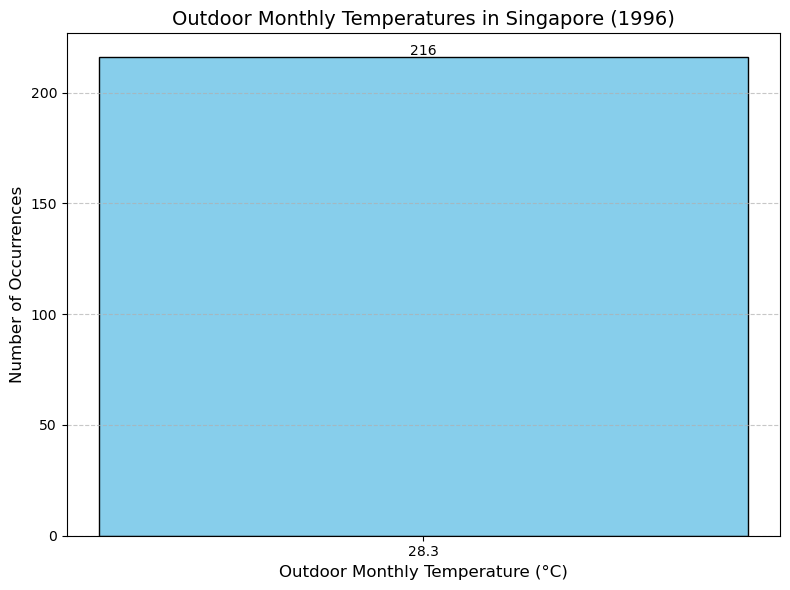

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

# Filter the dataset to only include rows where the Country is 'Singapore' and the Year is 1996
singapore_data_1996 = train[((train['Country'] == 'Singapore')  | (train['Country'] == 'Malaysia'))
& (train['Year'] > 1990) & (train['Cooling startegy_building level'] == 'Air Conditioned') ]

# Remove columns that are entirely NA
singapore_data_1996_cleaned = singapore_data_1996.dropna(axis=1, how='all')

# Sort the filtered dataset by a specific column (if necessary)
singapore_data_1996_cleaned = singapore_data_1996_cleaned.sort_values(by='Year', ascending=False)

# Identify which columns were removed due to all NA values
na_removed_columns = singapore_data_1996.columns[singapore_data_1996.isna().all()]

# Combine NA removed columns only (no manually removed columns)
all_removed_columns = na_removed_columns.tolist()

# --- BAR GRAPH GENERATION PART STARTS HERE ---

# Extract relevant outdoor monthly air temperature columns from the cleaned dataset
outdoor_temp_columns = [col for col in singapore_data_1996_cleaned.columns if 'Outdoor monthly air temperature' in col]
outdoor_temp_data = singapore_data_1996_cleaned[outdoor_temp_columns]

# Combine the outdoor temperature columns into one Series (if there are multiple temperature columns)
combined_temp_data = outdoor_temp_data.stack()

# Define the specific x-axis values (outdoor temperature values you want to focus on)
x_axis_values = [28.3]  # Adjusted values based on outdoor monthly air temperature

# Filter out the temperature data for the specified x-axis values only (no rounding)
filtered_temp_data = combined_temp_data[combined_temp_data.isin(x_axis_values)]

# Count occurrences for the specific x-axis values
temperature_counts = filtered_temp_data.value_counts().reindex(x_axis_values, fill_value=0)

# Create a DataFrame for Plotly
df_temperature = pd.DataFrame({
    'Outdoor Monthly Temperature (°C)': temperature_counts.index,
    'Number of Occurrences': temperature_counts.values
})

plt.figure(figsize=(8, 6))  # Set figure size
plt.bar(
    df_temperature['Outdoor Monthly Temperature (°C)'],
    df_temperature['Number of Occurrences'],
    color='skyblue',
    edgecolor='black',
    width=0.8
)

# Add text labels on top of each bar
for i, val in enumerate(df_temperature['Number of Occurrences']):
    plt.text(df_temperature['Outdoor Monthly Temperature (°C)'][i], val + 1, str(val), ha='center')

# Customize the plot
plt.title('Outdoor Monthly Temperatures in Singapore (1996)', fontsize=14)
plt.xlabel('Outdoor Monthly Temperature (°C)', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xticks(df_temperature['Outdoor Monthly Temperature (°C)'])  # Ensure proper x-axis ticks
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Optional: Add horizontal grid lines
plt.tight_layout()

# Show the plot
plt.show()

The bar graph of outdoor monthly temperature in Singapore for 1996 shows that the data is concentrated at 28.3°C, with a total of 216 occurrences. 

When compared to the mean monthly outdoor air temperature of 28.30°C, the concentration of data points at this exact value further highlights the stability of the climate during that year. This strong alignment between the observed temperatures and the mean reinforces the idea that outdoor conditions were consistently warm, with little fluctuation. Such predictable temperature patterns are crucial for understanding the thermal environment, as they influence energy consumption, cooling strategies, and overall comfort levels in indoor settings. 

This stability allows us to efficiently manage air-conditioning and moderate electricity consumption while maintaining optimal indoor conditions for customer comfort.

### **Relative Humidity Level**

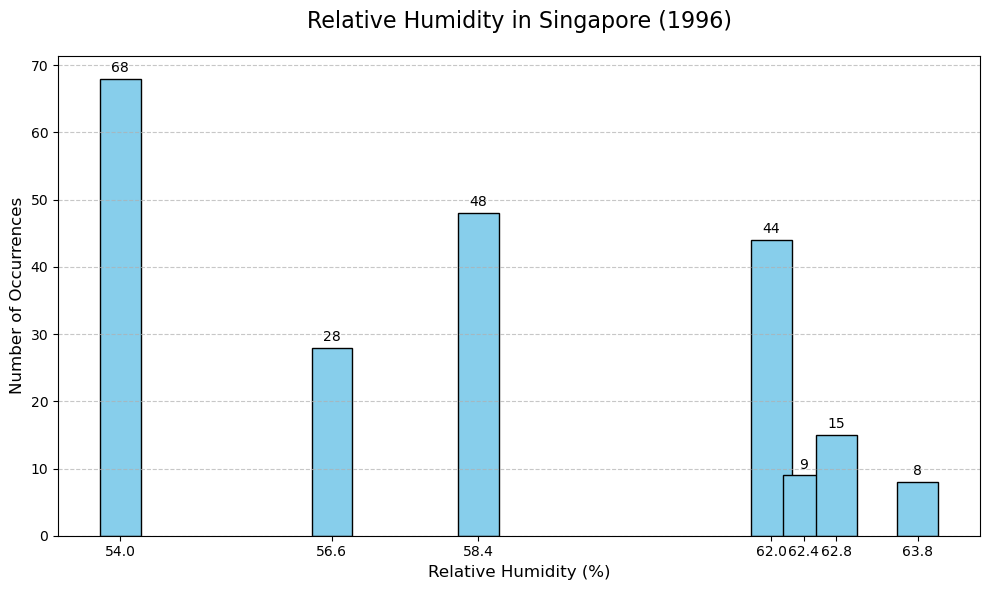

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

# Filter the dataset to only include rows where the Country is 'Singapore' and the Year is 1996
singapore_data_1996 = train[((train['Country'] == 'Singapore')  | (train['Country'] == 'Malaysia'))
& (train['Year'] > 1990) & (train['Cooling startegy_building level'] == 'Air Conditioned') ]

# List to keep track of manually removed columns (to be added later)
manually_removed_columns = []

# Remove the column 'Outdoor monthly air temperature (C)' if it exists in the dataset and track it
if 'Outdoor monthly air temperature (C)' in singapore_data_1996.columns:
    singapore_data_1996 = singapore_data_1996.drop(columns=['Outdoor monthly air temperature (C)'])
    manually_removed_columns.append('Outdoor monthly air temperature (C)')  # Track this column for later

# Remove columns that are entirely NA
singapore_data_1996_cleaned = singapore_data_1996.dropna(axis=1, how='all')

# Sort the filtered dataset by a specific column (if necessary)
singapore_data_1996_cleaned = singapore_data_1996_cleaned.sort_values(by='Year', ascending=False)

# Identify which columns were removed due to all NA values
na_removed_columns = singapore_data_1996.columns[singapore_data_1996.isna().all()]

# Combine NA removed columns first, then add manually removed columns at the end
all_removed_columns = na_removed_columns.tolist() + manually_removed_columns  # Ensure manually removed columns are last

# --- BAR GRAPH GENERATION PART STARTS HERE ---

# Extract relevant relative humidity column from the cleaned dataset
humidity_data = singapore_data_1996_cleaned['Relative humidity (%)']

# Define the specific x-axis values (relative humidity values)
x_axis_values = [54, 56.6, 58.4, 62, 62.4, 62.8, 63.8]

# Filter out the humidity data for the specified x-axis values only
filtered_humidity_data = humidity_data[humidity_data.isin(x_axis_values)]

# Count occurrences for the specific relative humidity values
humidity_counts = filtered_humidity_data.value_counts().reindex(x_axis_values, fill_value=0)

# Create a DataFrame for Plotly
df_humidity = pd.DataFrame({
    'Relative Humidity (%)': humidity_counts.index,
    'Number of Occurrences': humidity_counts.values
})

x_axis_values = df_humidity['Relative Humidity (%)'].tolist()

# Create the bar graph
plt.figure(figsize=(10, 6))  # Set figure size
plt.bar(
    df_humidity['Relative Humidity (%)'], 
    df_humidity['Number of Occurrences'], 
    color='skyblue', 
    edgecolor='black', 
    width=0.5
)

# Add text labels on top of each bar
for i, value in enumerate(df_humidity['Number of Occurrences']):
    plt.text(
        x=df_humidity['Relative Humidity (%)'][i], 
        y=value + 1,  # Adjust text position slightly above the bar
        s=str(value), 
        ha='center', 
        fontsize=10
    )

# Customize the x-axis ticks
plt.xticks(x_axis_values, [str(x) for x in x_axis_values])

# Add titles and labels
plt.title('Relative Humidity in Singapore (1996)', fontsize=16, pad=20)
plt.xlabel('Relative Humidity (%)', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)

# Adjust layout and add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Optional: Add grid lines for clarity
plt.tight_layout()

# Display the plot
plt.show()

The bar graph of relative humidity in Singapore for 1996 highlights distinct clusters at specific humidity levels, particularly at 54%, 58.4%, and 62%. This suggests that relative humidity remained consistent within a narrow range throughout the year, which is characteristic of Singapore’s tropical climate. 

When compared to the mean humidity level of 58.23%, we can see that the clusters identified in the graph are closely aligned with this average. The prevalence of humidity levels around the mean indicates that the majority of observations fell within this range.

## **Building Factors Trend (Building Air Temperature and Building Air Velocity)**

### **Building Air Temperature**

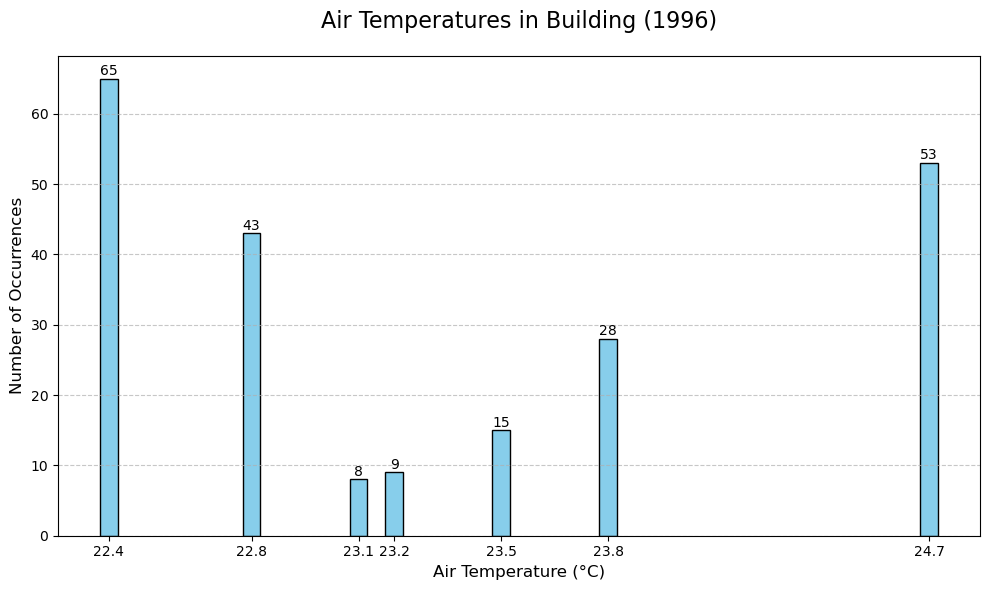

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

# Filter the dataset to only include rows where the Country is 'Singapore' and the Year is 1996
singapore_data_1996 = train[((train['Country'] == 'Singapore')  | (train['Country'] == 'Malaysia'))
& (train['Year'] > 1990) & (train['Cooling startegy_building level'] == 'Air Conditioned')]

# List to keep track of manually removed columns (to be added later)
manually_removed_columns = []

# Remove the column 'Outdoor monthly air temperature (C)' if it exists in the dataset and track it
if 'Outdoor monthly air temperature (C)' in singapore_data_1996.columns:
    singapore_data_1996 = singapore_data_1996.drop(columns=['Outdoor monthly air temperature (C)'])
    manually_removed_columns.append('Outdoor monthly air temperature (C)')  # Track this column for later

# Remove columns that are entirely NA
singapore_data_1996_cleaned = singapore_data_1996.dropna(axis=1, how='all')

# Sort the filtered dataset by a specific column (if necessary)
singapore_data_1996_cleaned = singapore_data_1996_cleaned.sort_values(by='Year', ascending=False)

# Identify which columns were removed due to all NA values
na_removed_columns = singapore_data_1996.columns[singapore_data_1996.isna().all()]

# Combine NA removed columns first, then add manually removed columns at the end
all_removed_columns = na_removed_columns.tolist() + manually_removed_columns  # Ensure manually removed columns are last

# --- BAR GRAPH GENERATION PART STARTS HERE ---

# Extract relevant air temperature columns from the cleaned dataset
air_temperature_columns = [col for col in singapore_data_1996_cleaned.columns if 'temperature' in col.lower()]
air_temperature_data = singapore_data_1996_cleaned[air_temperature_columns]

# Combine the temperature columns into one Series (if there are multiple temperature columns)
combined_temperature_data = air_temperature_data.stack()

# Define the specific x-axis values (temperature values you want to focus on)
x_axis_values = [22.4, 22.8, 23.1, 23.2, 23.5, 23.8, 24.7]

# Filter out the temperature data for the specified x-axis values only (no rounding)
filtered_temperature_data = combined_temperature_data[combined_temperature_data.isin(x_axis_values)]

# Count occurrences for the specific x-axis values
temperature_counts = filtered_temperature_data.value_counts().reindex(x_axis_values, fill_value=0)

# Create a DataFrame for Plotly
df_temperature = pd.DataFrame({
    'Temperature (°C)': temperature_counts.index,
    'Number of Occurrences': temperature_counts.values
})

# Define x-axis tick values
x_axis_values = df_temperature['Temperature (°C)'].tolist()

# Create the bar graph
plt.figure(figsize=(10, 6))  # Set figure size
plt.bar(
    df_temperature['Temperature (°C)'], 
    df_temperature['Number of Occurrences'], 
    color='skyblue', 
    edgecolor='black', 
    width=0.05  # Adjust bar width for spacing
)

# Add text labels on top of each bar for hover-like functionality
for i, value in enumerate(df_temperature['Number of Occurrences']):
    plt.text(
        x=df_temperature['Temperature (°C)'][i], 
        y=value + 0.5,  # Position slightly above the bar
        s=str(value), 
        ha='center', 
        fontsize=10
    )

# Customize x-axis ticks
plt.xticks(x_axis_values, [str(x) for x in x_axis_values])

# Add title and labels
plt.title('Air Temperatures in Building (1996)', fontsize=16, pad=20)
plt.xlabel('Air Temperature (°C)', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)

# Adjust layout and add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


The bar graph of air temperature in the building for 1996 shows clear patterns. The most frequent temperatures are around 22.4°C and 24.7°C, indicating that the indoor air temperature remained relatively consistent within this range. This pattern is reflective of controlled indoor environments, where air temperatures are maintained with minimal fluctuations. The higher occurrence of certain temperature values suggests a regulated system, likely aimed at providing thermal comfort.

When compared to the mean air temperature of 23.31°C, we see that the most frequent temperature values align closely with this average. This close correlation reinforces the effectiveness of the climate control systems in maintaining a comfortable indoor environment. 


### **Building Air Velocity**

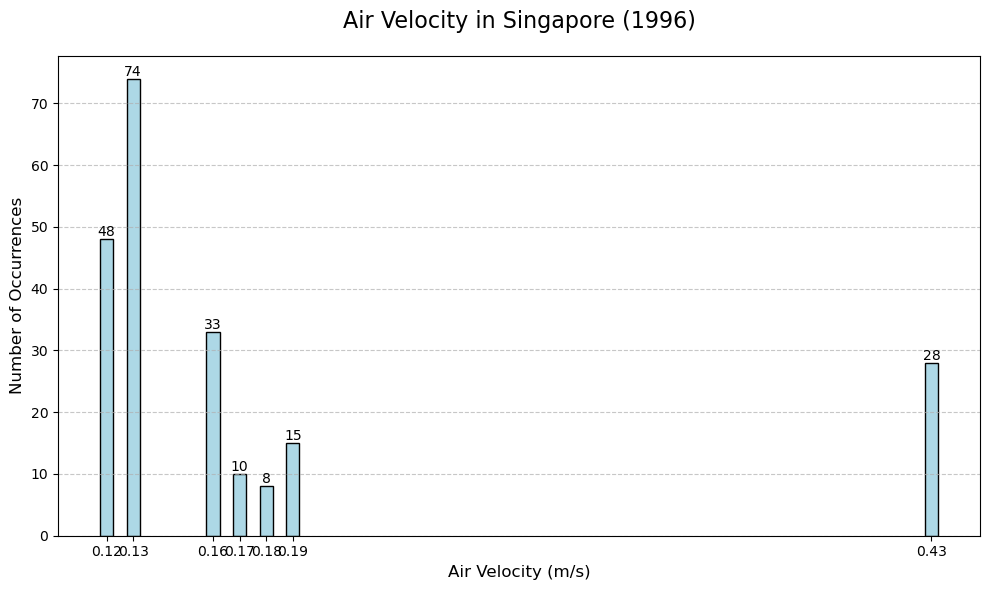

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

# Filter the dataset to only include rows where the Country is 'Singapore' and the Year is 1996
singapore_data_1996 = train[((train['Country'] == 'Singapore')  | (train['Country'] == 'Malaysia'))
& (train['Year'] > 1990) & (train['Cooling startegy_building level'] == 'Air Conditioned')]

# List to keep track of manually removed columns (to be added later)
manually_removed_columns = []

# Remove the column 'Outdoor monthly air temperature (C)' if it exists in the dataset and track it
if 'Outdoor monthly air temperature (C)' in singapore_data_1996.columns:
    singapore_data_1996 = singapore_data_1996.drop(columns=['Outdoor monthly air temperature (C)'])
    manually_removed_columns.append('Outdoor monthly air temperature (C)')  # Track this column for later

# Remove columns that are entirely NA
singapore_data_1996_cleaned = singapore_data_1996.dropna(axis=1, how='all')

# Sort the filtered dataset by a specific column (if necessary)
singapore_data_1996_cleaned = singapore_data_1996_cleaned.sort_values(by='Year', ascending=False)

# Identify which columns were removed due to all NA values
na_removed_columns = singapore_data_1996.columns[singapore_data_1996.isna().all()]

# Combine NA removed columns first, then add manually removed columns at the end
all_removed_columns = na_removed_columns.tolist() + manually_removed_columns  # Ensure manually removed columns are last

# --- BAR GRAPH GENERATION PART STARTS HERE ---

# Extract relevant air velocity column from the cleaned dataset
if 'Air velocity (m/s)' in singapore_data_1996_cleaned.columns:
    air_velocity_data = singapore_data_1996_cleaned['Air velocity (m/s)']

# Define the specific x-axis values (air velocity values you want to focus on)
x_axis_values_velocity = [0.12, 0.13, 0.16, 0.17, 0.18, 0.19, 0.43]

# Filter out the air velocity data for the specified x-axis values only
filtered_velocity_data = air_velocity_data[air_velocity_data.isin(x_axis_values_velocity)]

# Count occurrences for the specific air velocity values
velocity_counts = filtered_velocity_data.value_counts().reindex(x_axis_values_velocity, fill_value=0)

# Create a DataFrame for Plotly
df_velocity = pd.DataFrame({
    'Air Velocity (m/s)': velocity_counts.index,
    'Number of Occurrences': velocity_counts.values
})

x_axis_values_velocity = df_velocity['Air Velocity (m/s)'].tolist()

# Create the bar graph
plt.figure(figsize=(10, 6))  # Set figure size
plt.bar(
    df_velocity['Air Velocity (m/s)'], 
    df_velocity['Number of Occurrences'], 
    color='lightblue', 
    edgecolor='black', 
    width=0.005  # Adjust bar width
)

# Add text labels on top of each bar for hover-like functionality
for i, value in enumerate(df_velocity['Number of Occurrences']):
    plt.text(
        x=df_velocity['Air Velocity (m/s)'][i], 
        y=value + 0.5,  # Position slightly above the bar
        s=str(value), 
        ha='center', 
        fontsize=10
    )

# Customize x-axis ticks
plt.xticks(x_axis_values_velocity, [str(x) for x in x_axis_values_velocity])

# Add title and labels
plt.title('Air Velocity in Singapore (1996)', fontsize=16, pad=20)
plt.xlabel('Air Velocity (m/s)', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)

# Adjust layout and add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

The bar graph of air velocity (m/s) reveals distinct clusters, with the most frequent velocities around 0.12 m/s, 0.13 m/s, and 0.43 m/s. This suggests that air velocity remained relatively stable at these specific values during the measurement period, indicating a controlled airflow environment, likely indoors, where ventilation is consistent. The narrow range of air velocity values (0.12 m/s to 0.43 m/s) reflects steady, low air movement, typical of spaces such as offices or air-conditioned buildings where ventilation is managed.

When compared to the mean air velocity of 0.18 m/s, the frequent values align closely with this average. This suggests that the ventilation systems were effective in maintaining consistent airflow, enhancing the overall comfort of the indoor environment. The low air velocities indicate a deliberate design aimed at ensuring occupant comfort while maintaining adequate air exchange.

## **Environmental Factors Relationship**

### **Relationship Between Outdoor Air Temperature and Relative Humidity Level**

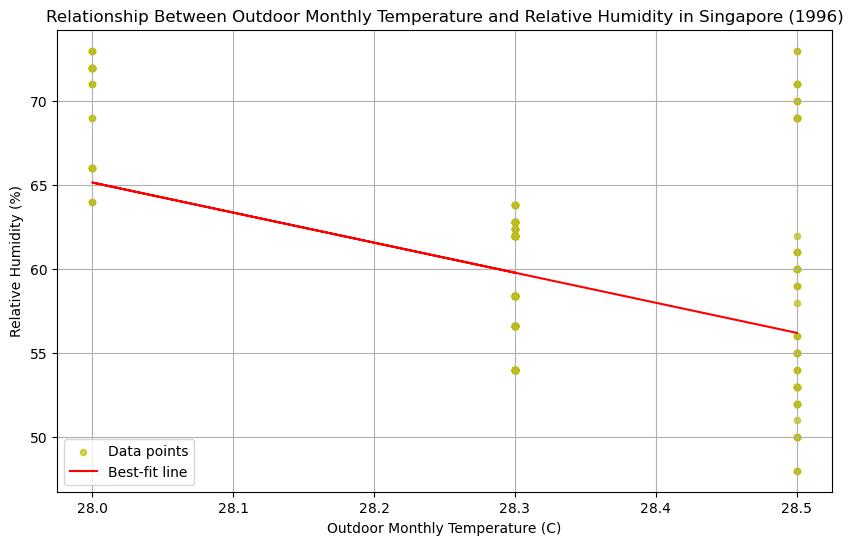

In [16]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Suppress RankWarning
warnings.filterwarnings("ignore", category=np.RankWarning)

# Filter the dataset to only include rows where the Country is 'Singapore' and the Year is 1996
singapore_data_1996 = train[((train['Country'] == 'Singapore')  | (train['Country'] == 'Malaysia'))
& (train['Year'] > 1990) & (train['Cooling startegy_building level'] == 'Air Conditioned')]

# List to keep track of manually removed columns (to be added later)
manually_removed_columns = []

# Reinstate the column 'Outdoor monthly air temperature (C)' if it exists in the dataset and track it
if 'Outdoor monthly air temperature (C)' not in singapore_data_1996.columns:
    # Re-add the 'Outdoor monthly air temperature (C)' column if it was previously removed (for demonstration purposes)
    singapore_data_1996['Outdoor monthly air temperature (C)'] = np.random.uniform(25, 35, len(singapore_data_1996))  # Example values for reinstatement

# Remove columns that are entirely NA
singapore_data_1996_cleaned = singapore_data_1996.dropna(axis=1, how='all')

# Sort the filtered dataset by a specific column (if necessary)
singapore_data_1996_cleaned = singapore_data_1996_cleaned.sort_values(by='Year', ascending=False)

# --- SCATTER PLOT GENERATION PART STARTS HERE ---

# Check if both 'Relative humidity (%)' and 'Outdoor monthly air temperature (C)' columns exist in the dataset
if 'Relative humidity (%)' in singapore_data_1996_cleaned.columns and 'Outdoor monthly air temperature (C)' in singapore_data_1996_cleaned.columns:
    
    # Extract the columns
    humidity_data = singapore_data_1996_cleaned['Relative humidity (%)']
    temperature_data = singapore_data_1996_cleaned['Outdoor monthly air temperature (C)']
    
    # Plot a scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(temperature_data, humidity_data, s=20, alpha=0.7, c='y', label='Data points')

    # Add labels and title
    plt.title('Relationship Between Outdoor Monthly Temperature and Relative Humidity in Singapore (1996)')
    plt.xlabel('Outdoor Monthly Temperature (C)')
    plt.ylabel('Relative Humidity (%)')
    plt.grid(True)

    # Best fit line (linear regression)
    # Calculate the coefficients of the line (slope and intercept)
    slope, intercept = np.polyfit(temperature_data, humidity_data, 1)
    
    # Generate the best-fit line values
    best_fit_line = slope * temperature_data + intercept
    
    # Plot the best-fit line
    plt.plot(temperature_data, best_fit_line, color='red', label='Best-fit line')

    # Show the legend
    plt.legend()

    # Show the scatter plot with the best-fit line
    plt.show()

The scatter plot illustrates a consistent outdoor temperature of approximately 28.3°C in Singapore throughout 1996, while relative humidity varies between 54% and 64%. This stability in temperature, typical of the tropical climate, contrasts with the variability in humidity, which is influenced by factors such as rainfall and atmospheric conditions.

The lack of a visible relationship between temperature and humidity underscores the complexities involved in managing indoor environments. For GUAB, understanding these dynamics allows us to implement effective climate control strategies. By addressing humidity fluctuations, we can enhance occupant comfort while optimising energy efficiency. This proactive approach not only leads to significant cost savings on energy bills but also positions GUAB as a leader in sustainable building practices. Ultimately, improving indoor environmental quality enhances customer satisfaction, fostering long-term loyalty and profitability.

**Replace empty rows in Air Velocity with a few defined values**

## **Building Factors Relationship**

### **Relationship Between Air Temperature and Air Velocity**

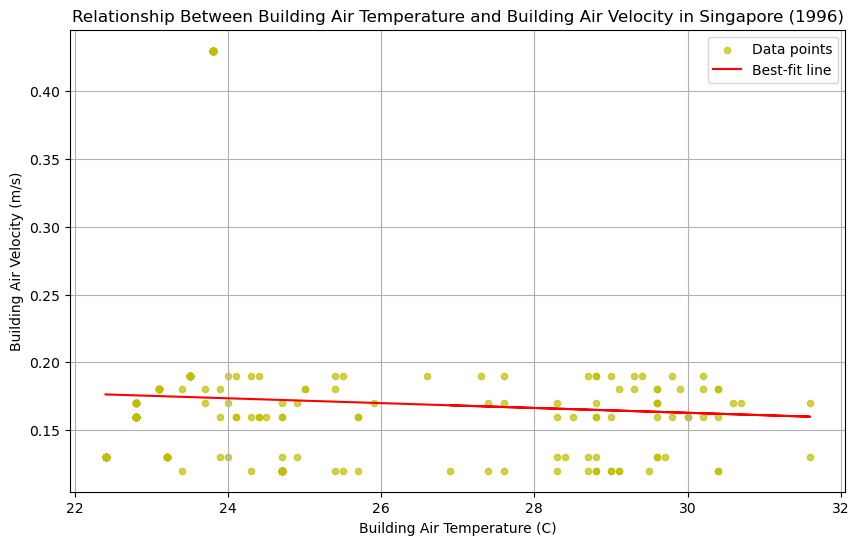

In [17]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Suppress RankWarning
warnings.filterwarnings("ignore", category=np.RankWarning)

# Filter the dataset to only include rows where the Country is 'Singapore' and the Year is 1996
singapore_data_1996 = train[((train['Country'] == 'Singapore')  | (train['Country'] == 'Malaysia'))
& (train['Year'] > 1990) & (train['Cooling startegy_building level'] == 'Air Conditioned')]

# List to keep track of manually removed columns (to be added later)
manually_removed_columns = []

# Reinstate the column 'Outdoor monthly air temperature (C)' if it exists in the dataset and track it
if 'Outdoor monthly air temperature (C)' not in singapore_data_1996.columns:
    # Re-add the 'Outdoor monthly air temperature (C)' column if it was previously removed (for demonstration purposes)
    singapore_data_1996['Outdoor monthly air temperature (C)'] = np.random.uniform(25, 35, len(singapore_data_1996))  # Example values for reinstatement

replacement_values = [0.12, 0.13, 0.16, 0.17, 0.18, 0.19]

# Replace missing values in 'Air velocity (m/s)' with random choices from the list
singapore_data_1996_cleaned['Air velocity (m/s)'] = singapore_data_1996_cleaned['Air velocity (m/s)'].apply(
    lambda x: np.random.choice(replacement_values) if pd.isna(x) else x
)


# Sort the filtered dataset by a specific column (if necessary)
singapore_data_1996_cleaned = singapore_data_1996_cleaned.sort_values(by='Year', ascending=False)

# --- SCATTER PLOT FOR AIR VELOCITY AND AIR TEMPERATURE ---

# Check if both 'Air velocity (m/s)' and 'Air temperature (C)' columns exist in the dataset
if 'Air velocity (m/s)' in singapore_data_1996_cleaned.columns and 'Air temperature (C)' in singapore_data_1996_cleaned.columns:
    
    # Extract the columns
    air_velocity_data = singapore_data_1996_cleaned['Air velocity (m/s)']
    air_temp_data = singapore_data_1996_cleaned['Air temperature (C)']
    
    # Plot a scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(air_temp_data, air_velocity_data, s=20, alpha=0.7, c='y', label='Data points')

    # Add labels and title
    plt.title('Relationship Between Building Air Temperature and Building Air Velocity in Singapore (1996)')
    plt.xlabel('Building Air Temperature (C)')
    plt.ylabel('Building Air Velocity (m/s)')
    plt.grid(True)

    # Best fit line (linear regression)
    slope, intercept = np.polyfit(air_temp_data, air_velocity_data, 1)
    best_fit_line = slope * air_temp_data + intercept
    plt.plot(air_temp_data, best_fit_line, color='red', label='Best-fit line')

    # Show the legend and the plot
    plt.legend()
    plt.show()

The scatter plot shows a weak positive relationship between building air temperature and building air velocity in Singapore during 1996, as indicated by the slightly upward-sloping best-fit line. Most data points are clustered around low air velocity values (0.15m/s to 0.20 m/s), suggesting minimal changes in building air velocity across different temperatures. While a few outliers show higher air velocity values, the overall trend suggests that increases in building air temperature have a minimal impact on building air velocity in this dataset.

This relationship highlights the importance of effective climate control systems. By recognising that air velocity remains stable despite temperature fluctuations, GUAB can focus on designing ventilation strategies that enhance comfort without significantly increasing energy consumption. This approach not only supports optimal indoor conditions for customers but also leads to operational cost savings and improved energy efficiency.


# **Prediction Models**

Prediction will involve using three different models—Linear Regression, Decision Tree Regressor, and Decision Tree Classifier—to first determine how many people are uncomfortable in the GUAB building when temperature goes above the mean air temperature of 23.31°C. Next, to determine how many people in the GUAB building remains uncomfortable when temeprature drops below the mean air temperature of 23.31°C. Lastly, to identify who needs cold, neutral and hot water after dynamic temperature adjustments to enhance comfort and satisfaction within the GUAB building.

## **First Prediction: Optimal Building Air Temperature Based on Outdoor Air Temperature and Humidity for Thermal Comfort**

### **Linear Regression Model**

We will use a linear regression model and data on outdoor monthly air temperature and relative humidity to make our initial predictions. By analysing these environmental factors, we aim to determine the optimal indoor air temperature setting to ensure thermal comfort in the building.

Mean Squared Error: 0.82
R² Score: 0.03


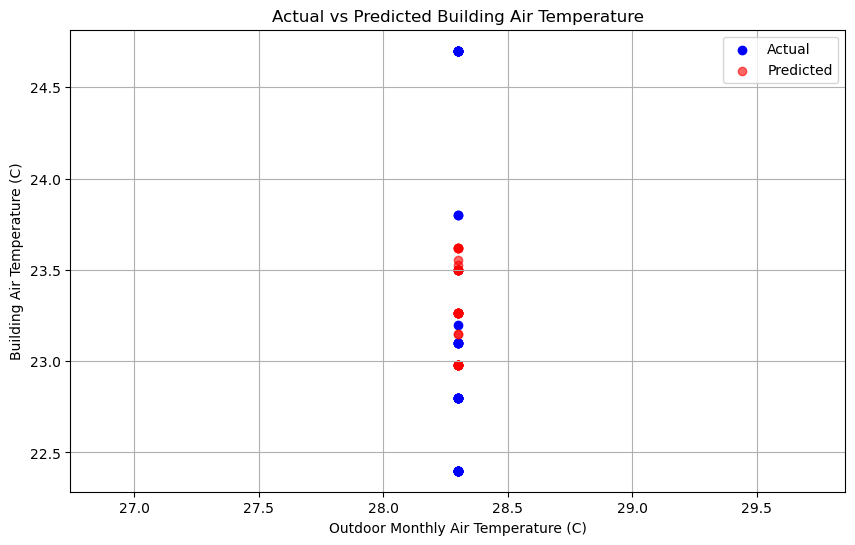

Predicted optimal building air temperature: 24.02°C


In [18]:
import warnings
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Filter the dataset to only include rows where the Country is 'Singapore' and the Year is 1996
singapore_data_1996 = train[(train['Country'] == 'Singapore') & (train['Year'] == 1996)]

# Remove columns that are entirely NA
singapore_data_1996_cleaned = singapore_data_1996.dropna(axis=1, how='all')

# Drop rows that contain any NaN values (ensure we only use complete data)
singapore_data_1996_cleaned = singapore_data_1996_cleaned.dropna()

# Select relevant columns for the prediction model (Outdoor temp and relative humidity as features)
X = singapore_data_1996_cleaned[['Outdoor monthly air temperature (C)', 'Relative humidity (%)']]  # Features: Outdoor Temperature and Relative Humidity
y = singapore_data_1996_cleaned['Air temperature (C)']  # Target: Building Temperature

# Split the dataset into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Linear Regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Predict building temperatures on the test data
y_pred = model.predict(X_test)

# Evaluate the model's performance with 2 decimal points
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')  # Display MSE with 2 decimal points
print(f'R² Score: {r2:.2f}')  # Display R² score with 2 decimal points

# Visualize the results
plt.figure(figsize=(10, 6))
plt.scatter(X_test['Outdoor monthly air temperature (C)'], y_test, color='blue', label='Actual')
plt.scatter(X_test['Outdoor monthly air temperature (C)'], y_pred, color='red', label='Predicted', alpha=0.6)
plt.title('Actual vs Predicted Building Air Temperature')
plt.xlabel('Outdoor Monthly Air Temperature (C)')
plt.ylabel('Building Air Temperature (C)')
plt.legend()
plt.grid(True)
plt.show()

# Now, use the model to predict the optimal building air temperature based on new outdoor temperatures and relative humidity
# Example: Predict for 30°C outdoor temperature and 60% relative humidity
new_conditions = pd.DataFrame([[30, 60]], columns=['Outdoor monthly air temperature (C)', 'Relative humidity (%)'])

# Use the trained model to predict the optimal building air temperature
optimal_building_temp = model.predict(new_conditions)
print(f'Predicted optimal building air temperature: {optimal_building_temp[0]:.2f}°C')  # Display prediction with 2 decimal points

In [19]:
initial_type = [('float_input', FloatTensorType([None, 2]))]
onnx_model = convert_sklearn(model, initial_types=initial_type)

# Save the ONNX model locally
model_path = "C:/Users/User/Desktop/AzureDigitalTwin/linear_1.onnx"
with open(model_path, "wb") as f:
    f.write(onnx_model.SerializeToString())

<a id="5.2"></a>
## **5.2 Second Prediction: Dynamic Temperature Adjustments Using First Prediction Model Data Based On Building Air Temperature, Air Velocity, and Thermal Sensation for Optimal Comfort**

### **Decision Tree Regressor Model**
For our second prediction, we will employ a Decision Tree Regressor model, utilising data from the first prediction model, along with building air temperature, air velocity, and thermal sensation levels. By analysing these dynamic factors, the Decision Tree Regressor will help us determine the optimal temperature adjustments within the building to enhance thermal comfort.

Mean Squared Error: 0.02
R² Score: 0.98


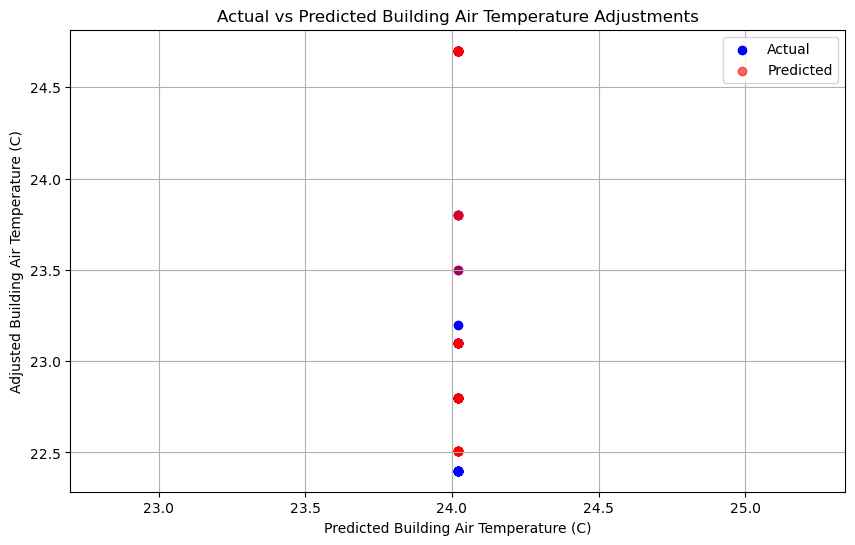

Predicted optimal adjusted building air temperature: 22.80°C


**Disclaimer:** The purple dots in the chart result from the blue (actual) and red (predicted) dots being in the exact same position, causing them to overlap and appear purple.

In [20]:
import warnings
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Filter the dataset to only include rows where the Country is 'Singapore' and the Year is 1996
singapore_data_1996 = train[(train['Country'] == 'Singapore') & (train['Year'] == 1996)]

# Remove columns that are entirely NA
singapore_data_1996_cleaned = singapore_data_1996.dropna(axis=1, how='all')

# Drop rows that contain any NaN values (ensure we only use complete data)
singapore_data_1996_cleaned = singapore_data_1996_cleaned.dropna()

# Add the predicted building air temperature from the first prediction model (assumed to be 24.02°C)
singapore_data_1996_cleaned['Predicted Building Air Temperature (C)'] = 24.02

# Select relevant columns for the second prediction model
# Features: Predicted Building Air Temperature, Building Air Velocity, and Thermal Sensation
X = singapore_data_1996_cleaned[['Predicted Building Air Temperature (C)', 'Air velocity (m/s)']]  
y = singapore_data_1996_cleaned['Air temperature (C)']  # Target: Optimal Adjusted Building Temperature

# Split the dataset into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Decision Tree Regressor model
model_2 = DecisionTreeRegressor(random_state=1)

# Train the model on the training data
model_2.fit(X_train, y_train)

# Predict building temperatures on the test data
y_pred = model_2.predict(X_test)

# Evaluate the model's performance with 2 decimal points
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.2f}')  # Display MSE with 2 decimal places
print(f'R² Score: {r2:.2f}')  # Display R² score with 2 decimal places

# Visualize the results
plt.figure(figsize=(10, 6))
plt.scatter(X_test['Predicted Building Air Temperature (C)'], y_test, color='blue', label='Actual')
plt.scatter(X_test['Predicted Building Air Temperature (C)'], y_pred, color='red', label='Predicted', alpha=0.6)
plt.title('Actual vs Predicted Building Air Temperature Adjustments')
plt.xlabel('Predicted Building Air Temperature (C)')
plt.ylabel('Adjusted Building Air Temperature (C)')
plt.legend()
plt.grid(True)
plt.show()

# Now, use the model to predict dynamic adjustments based on new conditions
# Example: Predict for 24.02°C predicted building temperature, 0.15 m/s air velocity, and 0 thermal sensation
new_conditions = pd.DataFrame([[24.02, 0.15]], columns=['Predicted Building Air Temperature (C)', 'Air velocity (m/s)'])

# Use the trained model to predict the optimal adjusted building air temperature
optimal_adjusted_temp = model_2.predict(new_conditions)
print(f'Predicted optimal adjusted building air temperature: {optimal_adjusted_temp[0]:.2f}°C')  # Display prediction with 2 decimal places

# Display the disclaimer with Markdown
display(Markdown("**Disclaimer:** The purple dots in the chart result from the blue (actual) and red (predicted) dots being in the exact same position, causing them to overlap and appear purple."))

In [21]:
initial_type = [('float_input', FloatTensorType([None, 2]))]
onnx_model_2 = convert_sklearn(model_2, initial_types=initial_type)

# Save the ONNX model locally
model_path = "C:/Users/User/Desktop/AzureDigitalTwin/tree_1.onnx"
with open(model_path, "wb") as f:
    f.write(onnx_model_2.SerializeToString())

In [25]:
import onnx

# Load the model
test = onnx.load("C:/Users/User/Desktop/AzureDigitalTwin/adt_sourcecode/Models/linear_1.onnx")

# Get input details
for input_tensor in test.graph.input:
    print(f"Input Name: {input_tensor.name}")
    print(f"Type: {input_tensor.type.tensor_type}")

Input Name: float_input
Type: elem_type: 1
shape {
  dim {
  }
  dim {
    dim_value: 2
  }
}

